# Redes Neuronales Recurrentes (RNN) y LSTM

Este notebook cubre las Redes Neuronales Recurrentes (RNN) y Long Short-Term Memory (LSTM), fundamentales para procesamiento de secuencias y series temporales.

## Introducción

Las RNN están diseñadas para trabajar con datos secuenciales donde el orden importa. Mantienen un estado oculto que captura información de pasos anteriores.

### Conceptos Clave

- **RNN**: Red que procesa secuencias manteniendo memoria de estados anteriores
- **LSTM**: Variante de RNN que resuelve el problema del gradiente desaparecido
- **GRU**: Gated Recurrent Unit, versión simplificada de LSTM
- **Backpropagation Through Time (BPTT)**: Algoritmo de entrenamiento para RNN
- **Vanishing Gradient**: Problema que limita el aprendizaje de dependencias a largo plazo


## Importar Librerías


In [1]:
# Suprimir mensajes informativos de TensorFlow
# IMPORTANTE: Estas variables deben establecerse ANTES de importar TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime INFO (1) y WARNING (2), muestra solo ERROR (3)
# Suprimir mensajes de absl (usado por TensorFlow)
os.environ['ABSL_MIN_LOG_LEVEL'] = '2'
# Deshabilitar GPU por defecto para evitar mensajes de inicialización
# Si necesitas usar GPU, comenta la siguiente línea después de ejecutar esta celda
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Fuerza uso de CPU (sin mensajes de GPU)
# Redirigir stderr temporalmente durante la importación y configuración para capturar warnings de GPU
import sys
from io import StringIO
stderr_backup = sys.stderr
stderr_capture = StringIO()
sys.stderr = stderr_capture

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Intentar importar TensorFlow/Keras
try:
    import tensorflow as tf
    # Configurar logging de TensorFlow para suprimir mensajes adicionales
    tf.get_logger().setLevel('ERROR')
    # Suprimir mensajes de absl (usado por TensorFlow para logging)
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)
    
    from tensorflow import keras
    from tensorflow.keras import layers, models
    
    # Configurar dispositivos: usar CPU por defecto (sin mensajes de GPU)
    # Limpiar el buffer de stderr
    stderr_capture.seek(0)
    stderr_capture.truncate(0)
    print("ℹ Usando CPU (sin mensajes de GPU)")
    
    # Restaurar stderr después de toda la configuración
    sys.stderr = stderr_backup
    
    TENSORFLOW_AVAILABLE = True
    print(f"✓ TensorFlow versión: {tf.__version__}")
    print("TensorFlow está disponible. Puedes ejecutar todos los ejemplos.")
except ImportError:
    # Restaurar stderr incluso si falla la importación
    sys.stderr = stderr_backup
    TENSORFLOW_AVAILABLE = False
    print("⚠ TensorFlow no está instalado.")
    print("   Para instalar TensorFlow, ejecuta: pip install tensorflow")
    print("   El notebook mostrará ejemplos de código pero no los ejecutará.")
except Exception as e:
    # Si hay cualquier otro error (como problemas de GPU), forzar CPU
    stderr_capture.seek(0)
    stderr_capture.truncate(0)
    sys.stderr = stderr_backup
    print(f"⚠ Error al configurar TensorFlow: {e}")
    print("   Intentando usar solo CPU...")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    try:
        # Redirigir stderr nuevamente para la segunda importación
        sys.stderr = StringIO()
        import tensorflow as tf
        tf.get_logger().setLevel('ERROR')
        tf.config.set_visible_devices([], 'GPU')
        from tensorflow import keras
        from tensorflow.keras import layers, models
        sys.stderr = stderr_backup
        TENSORFLOW_AVAILABLE = True
        print(f"✓ TensorFlow versión: {tf.__version__} (modo CPU)")
        print("TensorFlow está disponible en modo CPU.")
    except:
        sys.stderr = stderr_backup
        TENSORFLOW_AVAILABLE = False
        print("❌ No se pudo inicializar TensorFlow.")

np.random.seed(42)
if TENSORFLOW_AVAILABLE:
    tf.random.set_seed(42)
    
# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')


ℹ Usando CPU (sin mensajes de GPU)
✓ TensorFlow versión: 2.20.0
TensorFlow está disponible. Puedes ejecutar todos los ejemplos.


## 1. RNN Básica desde Cero

Implementemos una RNN simple para entender cómo funciona el procesamiento de secuencias.


Secuencia de entrada: [1 2 3 4 5]
Salida predicha: 0.0336
Valor objetivo: 6


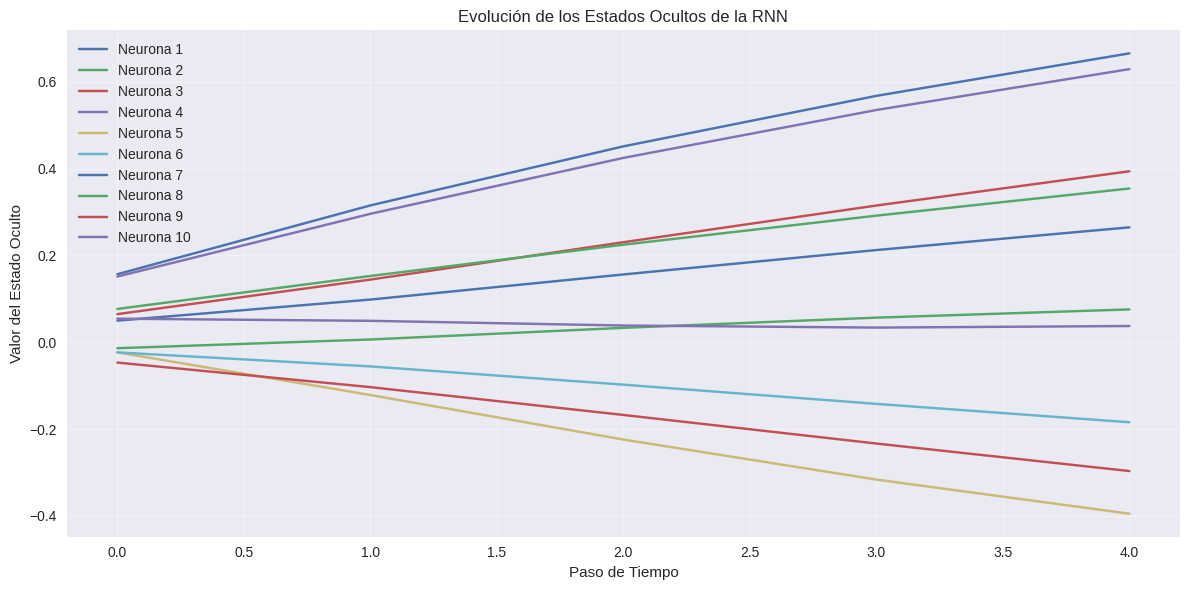

In [2]:
class SimpleRNN:
    """RNN básica para procesamiento de secuencias"""
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Pesos
        self.W_xh = np.random.randn(input_size, hidden_size) * 0.1
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.W_hy = np.random.randn(hidden_size, output_size) * 0.1
        
        # Biases
        self.b_h = np.zeros((1, hidden_size))
        self.b_y = np.zeros((1, output_size))
    
    def tanh(self, x):
        """Función de activación tanh"""
        return np.tanh(np.clip(x, -250, 250))
    
    def forward(self, X):
        """Propagación hacia adelante"""
        # X shape: (seq_length, batch_size, input_size)
        seq_length, batch_size, _ = X.shape
        
        self.hidden_states = [np.zeros((batch_size, self.hidden_size))]
        self.outputs = []
        
        for t in range(seq_length):
            # Calcular estado oculto
            h_t = self.tanh(
                np.dot(X[t], self.W_xh) + 
                np.dot(self.hidden_states[-1], self.W_hh) + 
                self.b_h
            )
            self.hidden_states.append(h_t)
            
            # Calcular salida
            y_t = np.dot(h_t, self.W_hy) + self.b_y
            self.outputs.append(y_t)
        
        return np.array(self.outputs)
    
    def predict(self, X):
        """Realizar predicción"""
        outputs = self.forward(X)
        return outputs[-1]  # Retornar última salida

# Ejemplo: Predicción de secuencia simple
# Entrenar a predecir el siguiente número en una secuencia
seq_length = 5
batch_size = 1
input_size = 1
hidden_size = 10
output_size = 1

rnn = SimpleRNN(input_size, hidden_size, output_size)

# Secuencia de ejemplo: [1, 2, 3, 4, 5] -> predecir 6
X = np.array([[[1]], [[2]], [[3]], [[4]], [[5]]])  # (seq_length, batch, input)
y_target = np.array([[6]])

# Forward pass
outputs = rnn.forward(X)
print(f"Secuencia de entrada: {X.flatten()}")
print(f"Salida predicha: {outputs[-1][0][0]:.4f}")
print(f"Valor objetivo: {y_target[0][0]}")

# Visualización de estados ocultos
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hidden_array = np.array([h[0] for h in rnn.hidden_states[1:]])
ax.plot(hidden_array)
ax.set_xlabel('Paso de Tiempo')
ax.set_ylabel('Valor del Estado Oculto')
ax.set_title('Evolución de los Estados Ocultos de la RNN')
ax.legend([f'Neurona {i+1}' for i in range(hidden_size)])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. LSTM con TensorFlow/Keras

Las LSTM resuelven el problema del gradiente desaparecido usando puertas (gates) que controlan el flujo de información.


✓ Forzando uso de CPU para evitar errores de CUDA
Arquitectura del modelo LSTM:


2025-12-07 21:05:43.482101: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo LSTM...
Epoch 1/20
4/4 - 2s - 459ms/step - loss: 0.3914 - mae: 0.5380 - val_loss: 0.2509 - val_mae: 0.4554
Epoch 2/20
4/4 - 0s - 14ms/step - loss: 0.3511 - mae: 0.5049 - val_loss: 0.2143 - val_mae: 0.4158
Epoch 3/20
4/4 - 0s - 14ms/step - loss: 0.3124 - mae: 0.4716 - val_loss: 0.1764 - val_mae: 0.3711
Epoch 4/20
4/4 - 0s - 14ms/step - loss: 0.2710 - mae: 0.4344 - val_loss: 0.1361 - val_mae: 0.3158
Epoch 5/20
4/4 - 0s - 14ms/step - loss: 0.2223 - mae: 0.3893 - val_loss: 0.0863 - val_mae: 0.2373
Epoch 6/20
4/4 - 0s - 14ms/step - loss: 0.1596 - mae: 0.3301 - val_loss: 0.0354 - val_mae: 0.1564
Epoch 7/20
4/4 - 0s - 14ms/step - loss: 0.0890 - mae: 0.2553 - val_loss: 0.0374 - val_mae: 0.1612
Epoch 8/20
4/4 - 0s - 15ms/step - loss: 0.0575 - mae: 0.2090 - val_loss: 0.1714 - val_mae: 0.4058
Epoch 9/20
4/4 - 0s - 15ms/step - loss: 0.0751 - mae: 0.2182 - val_loss: 0.0998 - val_mae: 0.3005
Epoch 10/20
4/4 - 0s - 15ms/step - loss: 0.0531 - mae: 0.1971 - val_loss: 0.0362 - val_mae

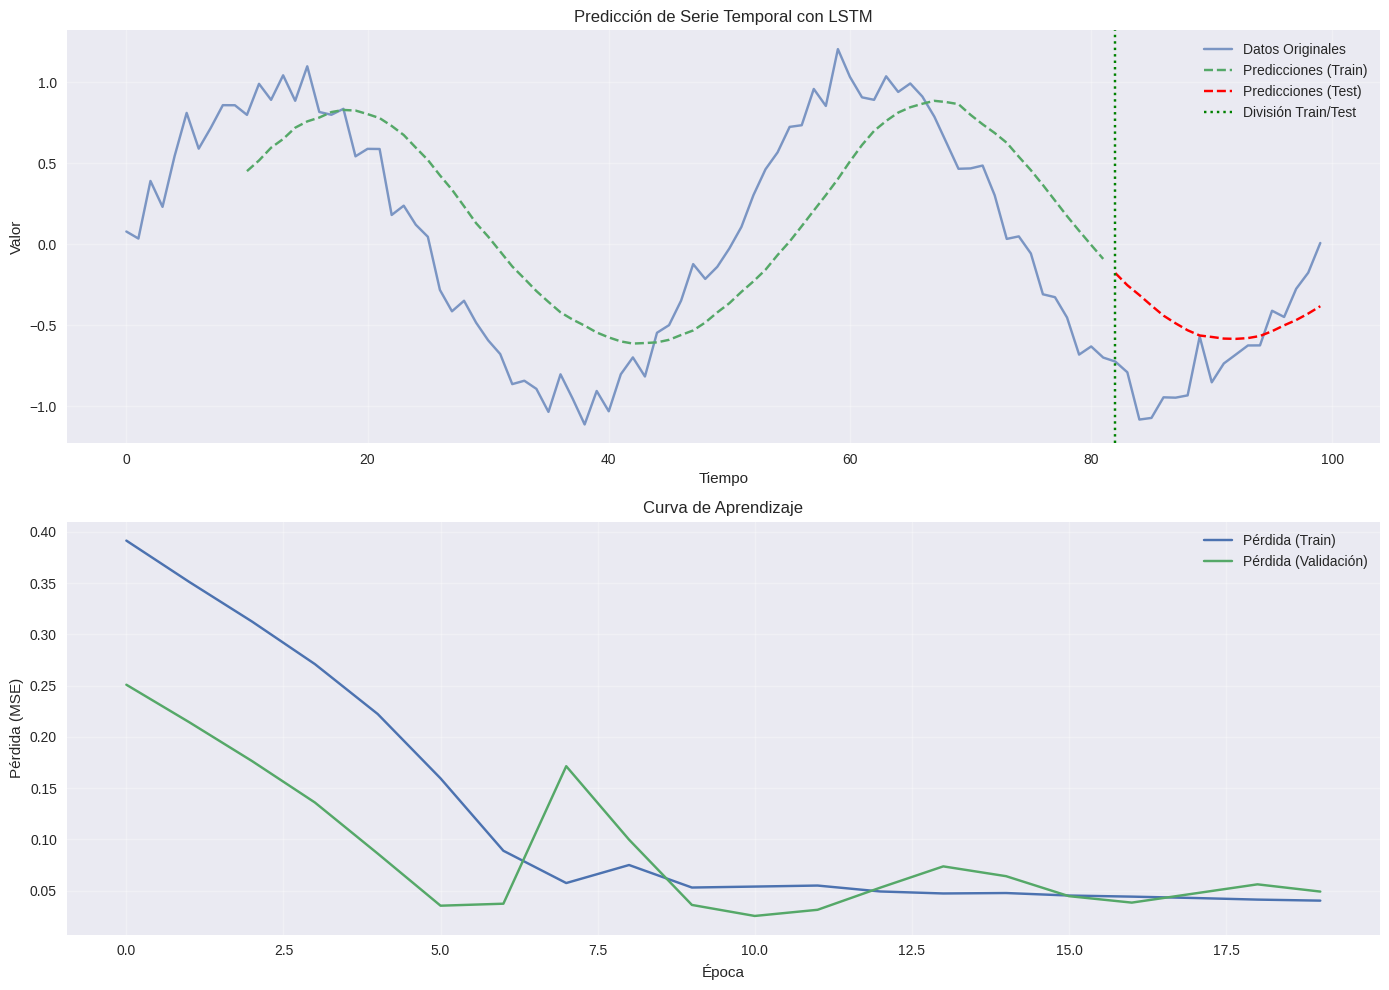


Métricas:
Train MSE: 0.2221, MAE: 0.4192
Test MSE: 0.1488, MAE: 0.3094


In [ ]:
if TENSORFLOW_AVAILABLE:
    # Forzar uso de CPU explícitamente (evita errores de CUDA)
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    # Asegurar que TensorFlow use solo CPU
    tf.config.set_visible_devices([], 'GPU')
    
    # Suprimir warnings adicionales durante la ejecución
    import logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # Verificar que estamos usando CPU
    print("✓ Forzando uso de CPU para evitar errores de CUDA")
    
    # Generar datos de serie temporal sintética
    time_steps = 100
    t = np.linspace(0, 4*np.pi, time_steps)
    data = np.sin(t) + 0.1 * np.random.randn(time_steps)
    
    # Preparar datos para predicción de secuencia
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)
    
    seq_length = 10
    X, y = create_sequences(data, seq_length)
    
    # Normalizar: usar scalers separados para X e y
    # X tiene shape (samples, seq_length), y tiene shape (samples,)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Normalizar X: reshape a 2D para MinMaxScaler
    X_scaled = scaler_X.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
    # Normalizar y
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Reshape para LSTM: (samples, time_steps, features)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    
    # Dividir en train/test
    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]
    
    # Construir modelo LSTM
    model = models.Sequential([
        layers.LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        layers.LSTM(50, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    print("Arquitectura del modelo LSTM:")
    model.summary()
    
    # Entrenar
    print("\nEntrenando modelo LSTM...")
    # Usar verbose=2 para mostrar solo una línea por época (más limpio)
    history = model.fit(X_train, y_train, 
                       epochs=20, 
                       batch_size=16,
                       validation_split=0.2,
                       verbose=2)
    
    # Predicciones
    train_pred = model.predict(X_train, verbose=0)
    test_pred = model.predict(X_test, verbose=0)
    
    # Desnormalizar usando el scaler de y
    train_pred = scaler_y.inverse_transform(train_pred)
    test_pred = scaler_y.inverse_transform(test_pred)
    y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Visualización
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Datos originales y predicciones
    train_indices = range(seq_length, seq_length + len(train_pred))
    test_indices = range(seq_length + len(train_pred), seq_length + len(train_pred) + len(test_pred))
    
    axes[0].plot(data, label='Datos Originales', alpha=0.7)
    axes[0].plot(train_indices, train_pred, label='Predicciones (Train)', linestyle='--')
    axes[0].plot(test_indices, test_pred, label='Predicciones (Test)', linestyle='--', color='red')
    axes[0].axvline(split + seq_length, color='green', linestyle=':', label='División Train/Test')
    axes[0].set_xlabel('Tiempo')
    axes[0].set_ylabel('Valor')
    axes[0].set_title('Predicción de Serie Temporal con LSTM')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Curva de aprendizaje
    axes[1].plot(history.history['loss'], label='Pérdida (Train)')
    axes[1].plot(history.history['val_loss'], label='Pérdida (Validación)')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Pérdida (MSE)')
    axes[1].set_title('Curva de Aprendizaje')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calcular métricas
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    train_mse = mean_squared_error(y_train_orig, train_pred)
    test_mse = mean_squared_error(y_test_orig, test_pred)
    train_mae = mean_absolute_error(y_train_orig, train_pred)
    test_mae = mean_absolute_error(y_test_orig, test_pred)
    
    print(f"\nMétricas:")
    print(f"Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}")
    print(f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")
    
else:
    print("TensorFlow no está disponible. Instala con: pip install tensorflow")
    print("\nEjemplo de arquitectura LSTM típica:")
    print("""
    Input (seq_length, features)
        ↓
    LSTM (50 unidades, return_sequences=True)
        ↓
    LSTM (50 unidades)
        ↓
    Dense (1)
        ↓
    Output (predicción)
    """)
    print("\nComponentes de una celda LSTM:")
    print("- Forget Gate: Decide qué información olvidar")
    print("- Input Gate: Decide qué nueva información almacenar")
    print("- Cell State: Transporta información a través de la secuencia")
    print("- Output Gate: Decide qué parte del cell state usar como salida")



Entrenando SimpleRNN...

Entrenando LSTM...

Entrenando GRU...


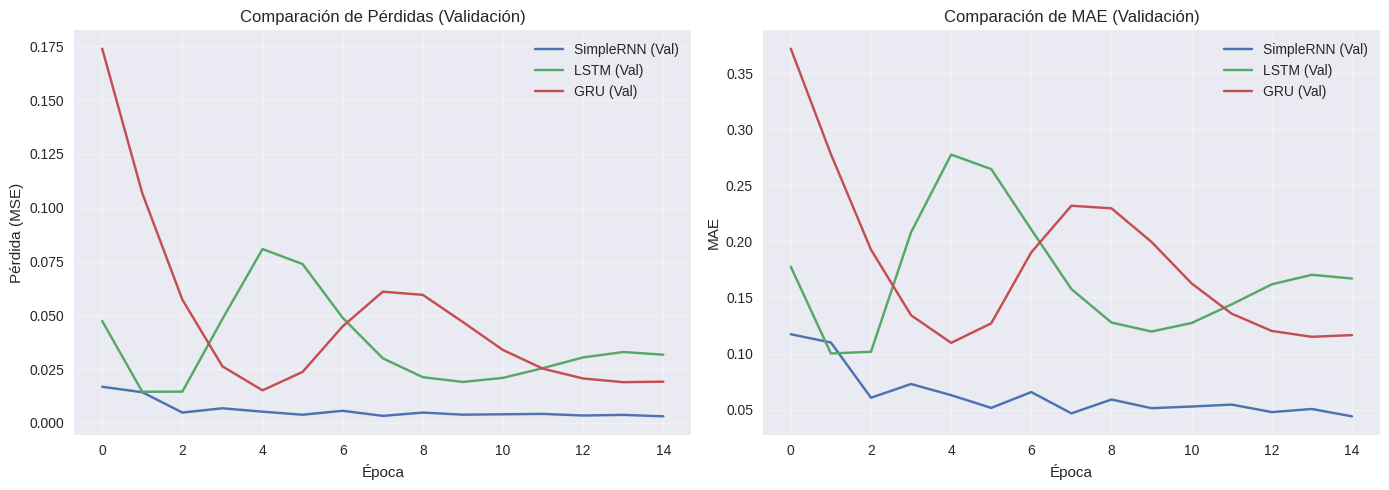


Comparación de parámetros:
SimpleRNN: 1,121 parámetros
LSTM: 4,385 parámetros
GRU: 3,393 parámetros


In [4]:
if TENSORFLOW_AVAILABLE:
    # Crear modelos comparativos
    models_dict = {
        'SimpleRNN': models.Sequential([
            layers.SimpleRNN(32, input_shape=(seq_length, 1)),
            layers.Dense(1)
        ]),
        'LSTM': models.Sequential([
            layers.LSTM(32, input_shape=(seq_length, 1)),
            layers.Dense(1)
        ]),
        'GRU': models.Sequential([
            layers.GRU(32, input_shape=(seq_length, 1)),
            layers.Dense(1)
        ])
    }
    
    # Compilar y entrenar cada modelo
    histories = {}
    for name, model in models_dict.items():
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        print(f"\nEntrenando {name}...")
        history = model.fit(X_train, y_train, 
                           epochs=15, 
                           batch_size=16,
                           validation_split=0.2,
                           verbose=0)
        histories[name] = history
    
    # Visualización comparativa
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Comparar pérdidas
    for name, history in histories.items():
        axes[0].plot(history.history['val_loss'], label=f'{name} (Val)')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Pérdida (MSE)')
    axes[0].set_title('Comparación de Pérdidas (Validación)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Comparar MAE
    for name, history in histories.items():
        axes[1].plot(history.history['val_mae'], label=f'{name} (Val)')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Comparación de MAE (Validación)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Comparar número de parámetros
    print("\nComparación de parámetros:")
    for name, model in models_dict.items():
        total_params = model.count_params()
        print(f"{name}: {total_params:,} parámetros")
    
else:
    print("TensorFlow no está disponible.")
    print("\nComparación de arquitecturas:")
    print("""
    SimpleRNN:
    - Más simple y rápida
    - Problema de gradiente desaparecido
    - Buena para secuencias cortas
    
    LSTM:
    - Resuelve el problema del gradiente desaparecido
    - 3 puertas (forget, input, output)
    - Mejor para dependencias a largo plazo
    - Más parámetros que RNN
    
    GRU:
    - Versión simplificada de LSTM
    - 2 puertas (reset, update)
    - Menos parámetros que LSTM
    - Rendimiento similar a LSTM en muchos casos
    """)


## 4. Resumen

### Diferencias Clave

**RNN Simple:**
- Mantiene un estado oculto simple
- Problema del gradiente desaparecido
- Eficiente pero limitada

**LSTM:**
- Cell state y hidden state separados
- 3 puertas para controlar flujo de información
- Excelente para dependencias a largo plazo

**GRU:**
- Combinación de cell state y hidden state
- 2 puertas (más simple que LSTM)
- Buen equilibrio entre complejidad y rendimiento

### Aplicaciones

- **Procesamiento de lenguaje natural**: Traducción, generación de texto
- **Series temporales**: Predicción de valores futuros
- **Reconocimiento de voz**: Transcripción de audio
- **Análisis de sentimientos**: Clasificación de texto
- **Modelado de secuencias**: Música, video
